            Date        Open        High         Low       Close   Adj Close  \
0     1986-03-13    0.088542    0.101563    0.088542    0.097222    0.060396   
1     1986-03-14    0.097222    0.102431    0.097222    0.100694    0.062553   
2     1986-03-17    0.100694    0.103299    0.100694    0.102431    0.063632   
3     1986-03-18    0.102431    0.103299    0.098958    0.099826    0.062014   
4     1986-03-19    0.099826    0.100694    0.097222    0.098090    0.060936   
...          ...         ...         ...         ...         ...         ...   
9460  2023-09-26  315.130005  315.880005  310.019989  312.140015  312.140015   
9461  2023-09-27  312.299988  314.299988  309.690002  312.790009  312.790009   
9462  2023-09-28  310.989990  315.480011  309.450012  313.640015  313.640015   
9463  2023-09-29  317.750000  319.470001  314.980011  315.750000  315.750000   
9464  2023-10-02  316.279999  321.890015  315.179993  321.799988  321.799988   

          Volume  
0     1031788800  
1

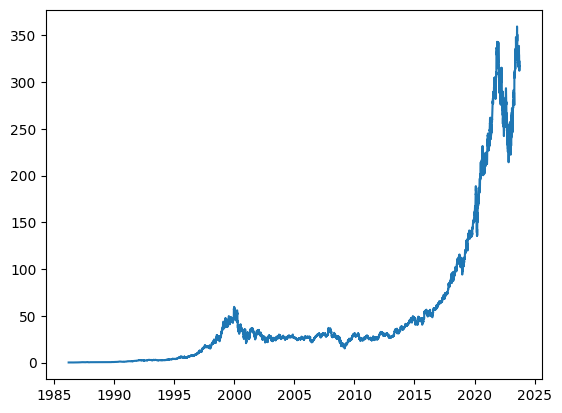

In [17]:
#Dataset @https://finance.yahoo.com/quote/MSFT/history?period1=511056000&period2=1696291200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

import pandas as pd

df = pd.read_csv(r'C:\Users\sbose\Downloads\MSFT.csv')

print(df)

import datetime
def str_to_datetime(s):
    split = s.split('-')
    year,month,day=int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year,month=month,day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

#make all of these date strings to actual date object

df['Date']=df['Date'].apply(str_to_datetime)
df['Date']

#Now we have to make the date column as index

df.index=df.pop('Date')
df

#now we have to plot our data using matplotlib
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])


Since we are using LSTM model we need to convert it into supervised learning problem
window df- a data frame where we have a target date column , a target-3, target-2 and target-1
here the window data frame is converting a date into getting its three previous values

In [18]:

import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


convert these into numpy arrays--> feed it directly into the tensorflow model

In [19]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

Split the data into train validation and testing partitions

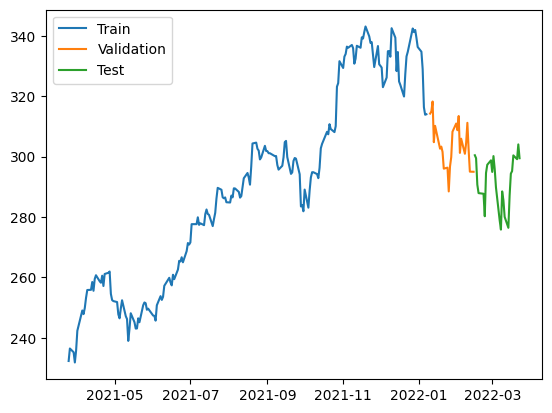

In [20]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 2s 67ms/step - loss: 84229.6484 - mean_absolute_error: 288.4787 - val_loss: 91790.4531 - val_mean_absolute_error: 302.8820
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 83754.0000 - mean_absolute_error: 287.6500 - val_loss: 91167.0625 - val_mean_absolute_error: 301.8511
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 83183.3750 - mean_absolute_error: 286.6600 - val_loss: 90589.4219 - val_mean_absolute_error: 300.8928
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 82596.8672 - mean_absolute_error: 285.6307 - val_loss: 89889.7266 - val_mean_absolute_error: 299.7278
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 81873.0000 - mean_absolute_error: 284.3574 - val_loss: 89005.8594 - val_mean_absolute_error: 298.2496
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 80897.3672 - mean_absolute_error: 282.6394 - val_loss: 87714.

7/7 [==============================] - 0s 1ms/step


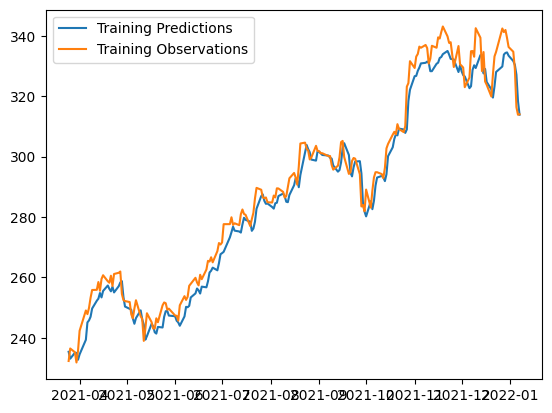

In [23]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 23ms/step


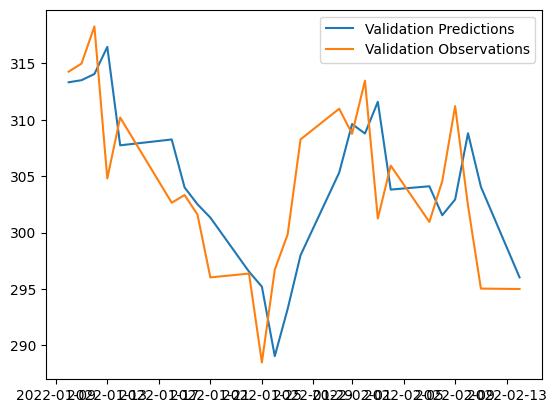

In [24]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 29ms/step


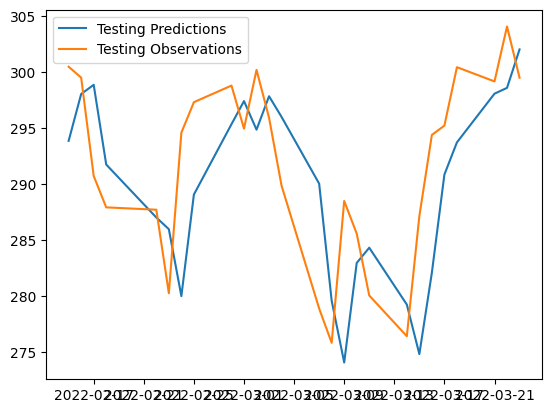

In [25]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

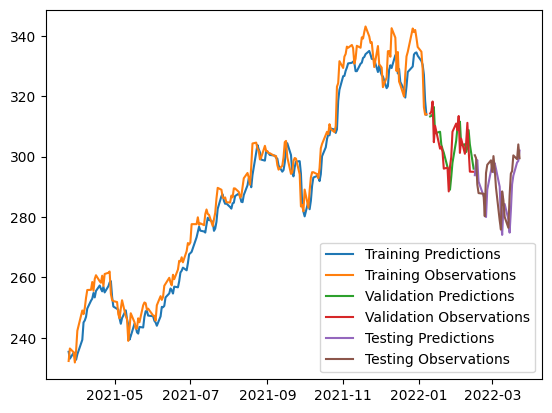

In [26]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

1/1 [==============================] - 0s 29ms/step


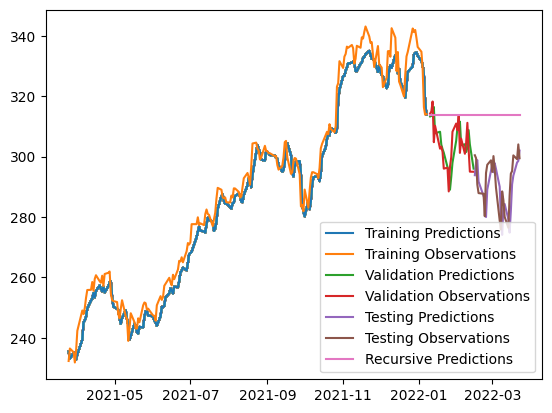

In [27]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction


  plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])